# Exploratory Privacy Risk Analysis

In [1]:
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display
from matplotlib import pylab as plt
from scipy.spatial.distance import cdist

In [2]:
import sys

sys.path.insert(0, "..")

from synthflow.__main__ import (
    REAL_DATASET_SCHEMA,
    _print_validate_coerce,
    _run_evaluation,
)
from tests.utils import (
    PROCESSED_REAL_DATA_200K_PATH,
    REAL_DATA_200K_PATH,
    SYNTH_DATA_200K_PATH,
)

In [3]:
rng = np.random.default_rng(1337)

## Distance Based Metrics

Synth could be closer to real!

In [4]:
# GAN evaluation paper, I'm not sure it appears in the Test Drive
# Maybe it is "Nearest Neighbor Distance Ratio"? But no report
def avg_abs_nn_dist(x, y):
    is_same = x is y

    if len(x.shape) == 1:
        x = x[:, None]
    if len(y.shape) == 1:
        y = y[:, None]

    dists = cdist(x, y)

    if is_same:
        np.fill_diagonal(dists, np.inf)

    nn_inds = dists.argmin(axis=1)
    return np.mean(np.abs(x - y[nn_inds]))


# https://github.com/hhunterzinck/absehrd/blob/main/privacy.py
def dist_ecdf(x, y):
    if len(x.shape) == 1:
        x = x[:, None]
    if len(y.shape) == 1:
        y = y[:, None]

    dists_xx = cdist(x, x)
    np.fill_diagonal(dists_xx, np.nan)
    sns.ecdfplot(dists_xx.flatten(), label="real-real")

    dists_xy = cdist(x, y)
    sns.ecdfplot(dists_xy.flatten(), label="real-synth")

    plt.legend()

NN Ratio: 0.028850396806415633


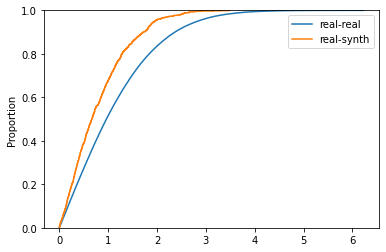

In [5]:
real = rng.normal(0, 1, 1000)
synth = rng.normal(0, 0, 1000)

print("NN Ratio:", avg_abs_nn_dist(synth, real) / avg_abs_nn_dist(real, real))

dist_ecdf(real, synth)

## Risks, Attacks and Mitigations

### Risk Overview

1. **Singling out**: the possibility to isolate some or all records which identify an individual in the dataset. See [Aloni & Nissim (2020)](https://www.pnas.org/doi/10.1073/pnas.1914598117).  
Why does it matters by itself? For example, (1) membership (whether a child was legally registered); (2) which data to collect to identify someone (target advertising)

2. **Linkability**: the ability to link, at least, two records concerning the same data subject or a group of data subjects (either in the same database or in two different databases). If an attacker can establish (e.g. by means of correlation analysis) that two records are assigned to a same group of individuals but cannot single out individuals in this group, the technique provides resistance against “singling out” but not against linkability;

3. **Inference**: the possibility to deduce, with significant probability, the value of an attribute from the values of a set of other attributes.

4. **Memebership**: the possibility to deduce, with significant probability, whether a original record was used to generate the released records.

1, 2, 3 - taken from the [GDPR ARTICLE 29 DATA PROTECTION WORKING PARTY](https://ec.europa.eu/justice/article-29/documentation/opinion-recommendation/files/2014/wp216_en.pdf)


### Baselines
1. Uniform (`br`)
2. Univariate (`bu`)
3. Univarate from synththic data without unique rows (`snubu`)
4. Univariate from MoH publications and guesses (`mohu`)


In [6]:
real_df = pd.read_csv(REAL_DATA_200K_PATH)
real_df = _print_validate_coerce(real_df, "Real", REAL_DATASET_SCHEMA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   mother_age      200000 non-null  int64 
 1   parity          200000 non-null  int64 
 2   gestation_week  200000 non-null  int64 
 3   is_female       200000 non-null  bool  
 4   birth_weight    200000 non-null  int64 
 5   date_of_birth   200000 non-null  object
dtypes: bool(1), int64(4), object(1)
memory usage: 7.8+ MB


In [7]:
processed_real_df = pd.read_pickle(PROCESSED_REAL_DATA_200K_PATH)
synth_df = pd.read_pickle(SYNTH_DATA_200K_PATH)

COLUMNS = list(processed_real_df.columns)

In [8]:
QUASI_IDENTIFIER_COLUMNS = ["date_of_birth", "mother_age", "parity", "is_female"]
SENSITIVE_COLUMNS = ["gestation_week", "birth_weight"]

In [9]:
def normalized_counter(seq):
    counter = Counter(seq)
    total = sum(counter.values())
    norm_counter = {element: count / total for element, count in counter.items()}
    return norm_counter


processed_real_weights = {
    column: normalized_counter(processed_real_df[column])
    for column in processed_real_df
}

unifrom_baseline_df = pd.DataFrame(
    {
        column: rng.choice(
            list(weights.keys()), size=len(processed_real_df), replace=True
        )
        for column, weights in processed_real_weights.items()
    }
)

univariate_baseline_df = pd.DataFrame(
    {
        column: rng.choice(
            list(weights.keys()),
            size=len(processed_real_df),
            replace=True,
            p=list(weights.values()),
        )
        for column, weights in processed_real_weights.items()
    }
)

In [10]:
synth_non_unique = synth_df[synth_df.duplicated(keep=False)]
synth_non_unique_weights = {
    column: normalized_counter(synth_non_unique[column]) for column in synth_non_unique
}

synth_non_unique_univariate_baseline_df = pd.DataFrame(
    {
        column: rng.choice(
            list(weights.keys()),
            size=len(processed_real_df),
            replace=True,
            p=list(weights.values()),
        )
        for column, weights in synth_non_unique_weights.items()
    }
)

In [11]:
synth_index = synth_df.set_index(list(synth_df.columns)).index
unique_processed_real_index = (
    processed_real_df.drop_duplicates(keep=False)
    .set_index(list(synth_df.columns))
    .index
)

mask = synth_index.isin(unique_processed_real_index) & ~synth_df.duplicated(keep=False)
synth_non_replicated_unique = synth_df[~mask]

synth_non_replicated_unique_weights = {
    column: normalized_counter(synth_non_replicated_unique[column])
    for column in synth_non_unique_univariate_baseline_df
}

synth_non_replicated_unique_univariate_baseline_df = pd.DataFrame(
    {
        column: rng.choice(
            list(weights.keys()),
            size=len(processed_real_df),
            replace=True,
            p=list(weights.values()),
        )
        for column, weights in synth_non_replicated_unique_weights.items()
    }
)

In [12]:
# https://www.gov.il/BlobFolder/reports/live-birth-in-israel/he/files_publications_units_info_birth_2000_2017.pdf

birth_weight_d = {}
birth_weight_d[pd.Interval(500, 600, closed="left")] = 0.04 / 100
birth_weight_d.update(
    {pd.Interval(w, w + 100, closed="left"): 0.04 / 100 for w in range(500, 1000, 100)}
)
birth_weight_d.update(
    {
        pd.Interval(w, w + 100, closed="left"): 0.6 / 5 / 100
        for w in range(1000, 1500, 100)
    }
)
birth_weight_d.update(
    {
        pd.Interval(w, w + 100, closed="left"): 1.4 / 5 / 100
        for w in range(1500, 2000, 100)
    }
)
birth_weight_d.update(
    {
        pd.Interval(w, w + 100, closed="left"): 5.4 / 5 / 100
        for w in range(2000, 2500, 100)
    }
)
birth_weight_d.update(
    {
        pd.Interval(w, w + 100, closed="left"): 21.7 / 5 / 100
        for w in range(2500, 3000, 100)
    }
)
birth_weight_d.update(
    {
        pd.Interval(w, w + 100, closed="left"): 41.5 / 5 / 100
        for w in range(3000, 3500, 100)
    }
)
birth_weight_d.update(
    {
        pd.Interval(w, w + 100, closed="left"): 23.9 / 5 / 100
        for w in range(3500, 4000, 100)
    }
)
birth_weight_d.update(
    {
        pd.Interval(w, w + 100, closed="left"): 4.9 / 5 / 100
        for w in range(4000, 4500, 100)
    }
)
birth_weight_d.update(
    {
        pd.Interval(w, w + 100, closed="left"): 0.4 / 5 / 100
        for w in range(4500, 4900, 100)
    }
)
birth_weight_d[pd.Interval(4900, 5001, closed="left")] = 0.4 / 5 / 100


moh_weights = {
    "mother_age": {
        pd.Interval(17, 18, closed="left"): 0.001,
        pd.Interval(18, 20, closed="left"): 1.7 / 100,
        pd.Interval(20, 25, closed="left"): 17.8 / 100,
        pd.Interval(25, 29, closed="left"): 29.1 / 100,
        pd.Interval(30, 35, closed="left"): 29.6 / 100,
        pd.Interval(35, 37, closed="left"): 8.35 / 100,
        pd.Interval(37, 40, closed="left"): 8.35 / 100,
        pd.Interval(40, 43, closed="left"): 4.6 / 100,
        pd.Interval(43, 51, closed="left"): 0.4 / 100,
    },
    "is_female": {False: 1 / (1 + 1.06), True: 1.06 / (1 + 1.06)},
    "date_of_birth": {
        pd.Timestamp(f"2019-{m:0d}-15 00:00:00"): 1 / 12 for m in range(1, 13)
    },
    "gestation_week": {
        pd.Interval(25, 26, closed="left"): 0,
        pd.Interval(26, 29, closed="left"): 0.2 / 100,
        pd.Interval(29, 32, closed="left"): 1 / 100,
        pd.Interval(32, 34, closed="left"): 1 / 100,
        pd.Interval(34, 37, closed="left"): 4.9 / 100,
        pd.Interval(37, 42, closed="left"): 89.9 / 100,
        pd.Interval(42, 43, closed="left"): 3 / 100,
    },
    # rounded version of bu:
    "parity": {
        pd.Interval(1, 2, closed="left"): 40 / 100,
        pd.Interval(2, 4, closed="left"): 50 / 100,
        pd.Interval(4, 7, closed="left"): 8 / 100,
        pd.Interval(7, 16, closed="left"): 2 / 100,
    },
    "birth_weight": birth_weight_d,
}


moh_univariate_baseline_df = pd.DataFrame(
    {
        column: rng.choice(
            list(weights.keys()),
            size=len(processed_real_df),
            replace=True,
            p=list(weights.values()),
        )
        for column, weights in moh_weights.items()
    }
)

In [13]:
pd.Series(
    {
        column: (
            pd.Series(synth_non_unique_weights[column])
            - pd.Series(processed_real_weights[column])
        )
        .abs()
        .max()
        for column in synth_non_unique_weights
    }
)

mother_age       0.00926
parity           0.01156
gestation_week   0.04415
is_female        0.00064
birth_weight     0.00441
date_of_birth    0.00186
dtype: float64

In [14]:
pd.Series(
    {
        column: (
            pd.Series(synth_non_replicated_unique_weights[column])
            - pd.Series(processed_real_weights[column])
        )
        .abs()
        .max()
        for column in synth_non_unique_weights
    }
)

mother_age       0.00286
parity           0.00255
gestation_week   0.01022
is_female        0.00074
birth_weight     0.00183
date_of_birth    0.00193
dtype: float64

In [15]:
pd.Series(
    {
        column: (
            pd.Series(synth_non_replicated_unique_weights[column])
            - pd.Series(synth_non_unique_weights[column])
        )
        .abs()
        .max()
        for column in synth_non_unique_weights
    }
)

mother_age       0.00640
parity           0.00901
gestation_week   0.03393
is_female        0.00010
birth_weight     0.00334
date_of_birth    0.00046
dtype: float64

In [16]:
pd.Series(
    {
        column: (
            pd.Series(moh_weights[column]) - pd.Series(processed_real_weights[column])
        )
        .abs()
        .max()
        for column in synth_non_unique_weights
    }
)

mother_age       0.01897
parity           0.03507
gestation_week   0.05446
is_female        0.02680
birth_weight     0.02419
date_of_birth    0.01006
dtype: float64

In [17]:
dfs = {
    "pr": processed_real_df,
    "s": synth_df,
    "bu": univariate_baseline_df,
    "br": unifrom_baseline_df,
    "snubu": synth_non_unique_univariate_baseline_df,
    "snrubu": synth_non_replicated_unique_univariate_baseline_df,
    "mohu": moh_univariate_baseline_df,
}

## 1. Singling Out

### Attack: Replicated Uniques
Determines which unique units in the synthesised data set(s) replicates unique units in the original observed data set.

### Metigation: Remove Uniques in Synth

In [18]:
count_df = (
    pd.concat({name: df[COLUMNS].value_counts() for name, df in dfs.items()}, axis=1)
    .fillna(0)
    .astype(int)
)

In [19]:
def attack_replicated_uniques(release, original, count_df):
    uniques = count_df.query(f"{release} == 1")
    intersections = count_df.query(f"{release} == 1 & {original} == 1")

    return {
        "Unique release count": len(uniques),
        "Unique KEYS in release perc": len(uniques)
        / len(count_df.query(f"{release} > 0"))
        * 100,
        "Unique ROWS in release perc": uniques[f"{release}"].sum()
        / count_df[release].sum()
        * 100,
        "Intersection in release count": len(intersections),
        "Intersection KEYS in release perc": len(intersections)
        / len(count_df.query(f"{release} > 0"))
        * 100,
        "Intersection ROWS in release perc": intersections[f"{release}"].sum()
        / count_df[release].sum()
        * 100,
    }


pd.DataFrame(
    {
        f"{name} vs. {count_df.columns[0]}": attack_replicated_uniques(
            name, count_df.columns[0], count_df
        )
        for name in count_df.columns[1:]
    }
).round(2)

,s vs. pr,bu vs. pr,br vs. pr,snubu vs. pr,snrubu vs. pr,mohu vs. pr
Unique release count,13693.00000,15792.00000,95509.00000,10693.00000,14654.00000,12958.00000
Unique KEYS in release perc,45.58000,46.72000,67.58000,41.41000,45.68000,45.24000
Unique ROWS in release perc,6.85000,7.90000,47.75000,5.35000,7.33000,6.48000
Intersection in release count,3129.00000,2413.00000,5122.00000,2036.00000,2291.00000,1703.00000
Intersection KEYS in release perc,10.42000,7.14000,3.62000,7.89000,7.14000,5.95000
Intersection ROWS in release perc,1.56000,1.21000,2.56000,1.02000,1.15000,0.85000


## 3. Inference

In [20]:
# counting / prec of sensitive column grouped by quasi


def attack_exact_apperent_match(release, original, nun_df):
    uniques = nun_df.query(f"nunique_{release} == 1")
    intersections = nun_df.query(f"nunique_{release} == 1 & nunique_{original} == 1")

    return {
        "Unique QUASI in release count": len(uniques),
        "Unique QUASY in release perc": len(uniques)
        / len(nun_df.query(f"size_{release} > 0"))
        * 100,
        "Unique ROWS in release count": uniques[f"size_{release}"].sum(),
        "Unique ROWS in release perc": uniques[f"size_{release}"].sum()
        / nun_df[f"size_{release}"].sum()
        * 100,
        "Intersection QUASI in release count": len(intersections),
        "Intersection QUASY in release perc": len(intersections)
        / len(nun_df.query(f"size_{release} > 0"))
        * 100,
        "Intersection ROWS in release count": intersections[f"size_{release}"].sum(),
        "Intersection ROWS in release perc": intersections[f"size_{release}"].sum()
        / nun_df[f"size_{release}"].sum()
        * 100,
    }
    return


nun_dfs = {
    column: pd.concat(
        [
            (
                df.groupby(QUASI_IDENTIFIER_COLUMNS)[column]
                .agg(["size", "nunique", lambda g: list(g)])
                .rename({"<lambda_0>": "values"}, axis=1)
                .add_suffix(f"_{name}")
            )
            for name, df in dfs.items()
        ],
        axis=1,
    )
    for column in SENSITIVE_COLUMNS
}

values_columns = [f"values_{name}" for name in dfs]

### `gestation_week`

#### Exact Match

,s vs. pr,bu vs. pr,br vs. pr,snubu vs. pr,snrubu vs. pr,mohu vs. pr
Unique QUASI in release count,32.00000,72.00000,0.00000,140.00000,85.00000,125.00000
Unique QUASY in release perc,4.31000,8.50000,0.00000,17.37000,10.16000,15.41000
Unique ROWS in release count,186.00000,266.00000,0.00000,668.00000,397.00000,669.00000
Unique ROWS in release perc,0.09000,0.13000,0.00000,0.33000,0.20000,0.33000
Intersection QUASI in release count,8.00000,7.00000,0.00000,12.00000,6.00000,9.00000
Intersection QUASY in release perc,1.08000,0.83000,0.00000,1.49000,0.72000,1.11000
Intersection ROWS in release count,29.00000,22.00000,0.00000,63.00000,32.00000,33.00000
Intersection ROWS in release perc,0.01000,0.01000,0.00000,0.03000,0.02000,0.02000


#### Approximate Match

{Interval(25, 26, closed='left'): 0,
 Interval(26, 29, closed='left'): 1,
 Interval(29, 32, closed='left'): 2,
 Interval(32, 34, closed='left'): 3,
 Interval(34, 37, closed='left'): 4,
 Interval(37, 42, closed='left'): 5,
 Interval(42, 43, closed='left'): 6}

/usr3/graduate/shlomi/.local/lib/python3.8/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr3/graduate/shlomi/.local/lib/python3.8/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr3/graduate/shlomi/.local/lib/python3.8/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

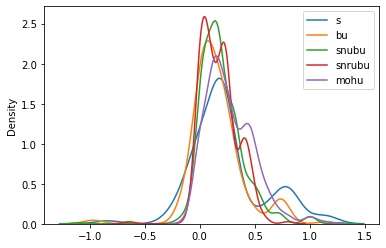

### `birth_weight`

#### Exact Match

,s vs. pr,bu vs. pr,br vs. pr,snubu vs. pr,snrubu vs. pr,mohu vs. pr
Unique QUASI in release count,1.00000,29.00000,0.00000,45.00000,28.00000,33.00000
Unique QUASY in release perc,0.13000,3.42000,0.00000,5.58000,3.35000,4.07000
Unique ROWS in release count,1.00000,32.00000,0.00000,46.00000,28.00000,34.00000
Unique ROWS in release perc,0.00000,0.02000,0.00000,0.02000,0.01000,0.02000
Intersection QUASI in release count,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
Intersection QUASY in release perc,0.00000,0.00000,0.00000,0.12000,0.00000,0.00000
Intersection ROWS in release count,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
Intersection ROWS in release perc,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


#### Approximate Match

{Interval(500, 600, closed='left'): 0,
 Interval(600, 700, closed='left'): 1,
 Interval(700, 800, closed='left'): 2,
 Interval(800, 900, closed='left'): 3,
 Interval(900, 1000, closed='left'): 4,
 Interval(1000, 1100, closed='left'): 5,
 Interval(1100, 1200, closed='left'): 6,
 Interval(1200, 1300, closed='left'): 7,
 Interval(1300, 1400, closed='left'): 8,
 Interval(1400, 1500, closed='left'): 9,
 Interval(1500, 1600, closed='left'): 10,
 Interval(1600, 1700, closed='left'): 11,
 Interval(1700, 1800, closed='left'): 12,
 Interval(1800, 1900, closed='left'): 13,
 Interval(1900, 2000, closed='left'): 14,
 Interval(2000, 2100, closed='left'): 15,
 Interval(2100, 2200, closed='left'): 16,
 Interval(2200, 2300, closed='left'): 17,
 Interval(2300, 2400, closed='left'): 18,
 Interval(2400, 2500, closed='left'): 19,
 Interval(2500, 2600, closed='left'): 20,
 Interval(2600, 2700, closed='left'): 21,
 Interval(2700, 2800, closed='left'): 22,
 Interval(2800, 2900, closed='left'): 23,
 Interval(2

/usr3/graduate/shlomi/.local/lib/python3.8/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr3/graduate/shlomi/.local/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr3/graduate/shlomi/.local/lib/python3.8/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

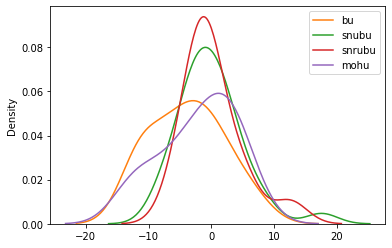

In [21]:
for sensitive_column in SENSITIVE_COLUMNS:
    display(Markdown(f"### `{sensitive_column}`"))

    display(Markdown("#### Exact Match"))
    nun_df = nun_dfs[sensitive_column]
    display(
        pd.DataFrame(
            {
                f"{name} vs. {count_df.columns[0]}": attack_exact_apperent_match(
                    name, count_df.columns[0], nun_dfs[sensitive_column]
                )
                for name in count_df.columns[1:]
            }
        ).round(2)
    )

    display(Markdown("#### Approximate Match"))

    cat2code = {
        y: x for x, y in enumerate(processed_real_df[sensitive_column].cat.categories)
    }
    display(cat2code)

    plt.figure()
    for name in count_df.columns[1:]:
        uniques_quasi = nun_dfs[sensitive_column].query(f"nunique_{name} == 1")
        uniques_quasi[values_columns] = uniques_quasi[values_columns].applymap(
            lambda x: np.mean([cat2code[y] for y in x])
            if isinstance(x, list)
            else np.nan
        )

        diffs = []
        for _, r in uniques_quasi.iterrows():
            size = r[f"size_{name}"]
            if not np.isnan(size):
                diffs += [
                    r[f"values_{name}"] - r[f"values_{count_df.columns[0]}"]
                    for _ in range(int(size))
                ]
        sns.kdeplot(diffs, label=name)
    plt.legend()
    plt.show()

## Mitigation

We have 3 strategies:
1. `resample_non_unique`: Remove unique rows and resample non-unique rows to reach back to N
2. `doubled_unique_without_replacement`: Remove unique rows and resample unique row double without replacement to reach back to N
3. `doubled_unique_with_replacement`: Remove unique rows and resample unique row double with replacement to reach back to N


Let $q = \frac{1}{N} \sum_{i=1}^{N} f(x_i)$ be a linear query on the data.

Applying $q$ on data genereted using strategy (1) is a *biased* estimator . The bias depands on how the unique rows are different then the rest of the data.
Strategy (2) and (3) gives us *unbiased* estimator, but the standard error of (2) is slightly better than (3) [ref](https://web.ma.utexas.edu/users/parker/sampling/woreplshort.htm).

In [22]:
def evaluate_acceptance(synth_df):
    *_, acceptance_df, _, _ = _run_evaluation(
        real_df,
        synth_df,
        0.4,
        42,
        processed_real_df,
        False,
        False,
    )

    return acceptance_df

In [23]:
unique_mask = ~synth_df.duplicated(keep=False)
num_uniques = unique_mask.sum()

In [24]:
non_unique_ids = np.nonzero(~unique_mask.values)[0]
new_non_unique_ids = rng.choice(non_unique_ids, num_uniques)


resample_non_unique_synth_df = pd.concat(
    [synth_df.iloc[non_unique_ids], synth_df.iloc[new_non_unique_ids]]
).reset_index(drop=True)

assert len(resample_non_unique_synth_df) == len(synth_df)

In [25]:
unique_ids = np.nonzero(unique_mask.values)[0]

num_unique_to_double, add_a_third = num_uniques // 2, num_uniques % 2

dobuled_uniqe_without_replacement_ids = rng.choice(
    unique_ids, size=num_unique_to_double, replace=False
)
dobuled_uniqe_with_replacement_ids = rng.choice(
    unique_ids, size=num_unique_to_double, replace=True
)

the_third_without_replacement = (
    rng.choice(dobuled_uniqe_without_replacement_ids) if add_a_third else []
)
the_third_with_replacement = (
    rng.choice(dobuled_uniqe_with_replacement_ids) if add_a_third else []
)

doubled_unique_without_replacement_synth_df = pd.concat(
    [
        synth_df[~unique_mask],
        synth_df.iloc[dobuled_uniqe_without_replacement_ids],
        synth_df.iloc[dobuled_uniqe_without_replacement_ids],
        synth_df.iloc[[the_third_without_replacement]],
    ]
).reset_index(drop=True)

doubled_unique_with_replacement_synth_df = pd.concat(
    [
        synth_df[~unique_mask],
        synth_df.iloc[dobuled_uniqe_with_replacement_ids],
        synth_df.iloc[dobuled_uniqe_with_replacement_ids],
        synth_df.iloc[[the_third_with_replacement]],
    ]
).reset_index(drop=True)

assert len(doubled_unique_without_replacement_synth_df) == len(synth_df)
assert len(doubled_unique_with_replacement_synth_df) == len(synth_df)

In [26]:
synth_df.value_counts().value_counts().sort_index().head()

1    13693
2     4624
3     2368
4     1572
5     1116
dtype: int64

In [27]:
resample_non_unique_synth_df.value_counts().value_counts().sort_index().head()

2    3982
3    2494
4    1629
5    1149
6     920
dtype: int64

In [28]:
doubled_unique_without_replacement_synth_df.value_counts().value_counts().sort_index().head()

2    11469
3     2369
4     1572
5     1116
6      830
dtype: int64

In [29]:
doubled_unique_with_replacement_synth_df.value_counts().value_counts().sort_index().head()

2    8806
3    2369
4    2601
5    1116
6    1010
dtype: int64

In [30]:
synth_acceptance_df = evaluate_acceptance(synth_df)

resample_non_unique_synth_acceptance_df = evaluate_acceptance(
    resample_non_unique_synth_df
)

doubled_unique_without_replacement_synth_acceptance_df = evaluate_acceptance(
    doubled_unique_without_replacement_synth_df
)

doubled_unique_with_replacement_synth_acceptance_df = evaluate_acceptance(
    doubled_unique_with_replacement_synth_df
)

100%|██████████| 1/1 [01:40<00:00, 100.94s/it]


DP Acceptance

HIGH_SENSITIVITY_EPSILON=0.3

LOW_SENSITIVITY_EPSILON=0.05

RATIO_MAX_CLIPPING_FACTOR=2

                                               name  expected   actual lower upper epsilon      var  sensitivity     mech check
0   utility/1way/max/frequencies/ratio/raw/val_pr_s   1.40000  1.14258     1     2 0.30000  0.01922      0.02941  laplace  True
1  utility/123way/max/frequencies/diff/raw/val_pr_s   0.01000  0.00445     0     1 0.01000  0.00000      0.00001  laplace  True
2           utility/mean/parity/mother_age/val_pr_s   0.30000  0.11300     1    15 0.01000  0.00010      0.00007  laplace  True
3          utility/mean/birth_weight/l_inf/val_pr_s 100.00000 96.63278   500  5000 0.01000 10.12500      0.02250  laplace  True
4        utility/mean/gestation_week/l_inf/val_pr_s   1.00000  0.43532    25    42 0.01000  0.00014      0.00009  laplace  True
5                       faithfulness/β/ɑ=1/val_pr_s   0.05000  0.03046     0     1 0.01000  0.00000      0.00001  laplace  True
6                                               all   1.00000  1.00000  None  None 0.35000     None     

100%|██████████| 1/1 [01:43<00:00, 103.95s/it]


DP Acceptance

HIGH_SENSITIVITY_EPSILON=0.3

LOW_SENSITIVITY_EPSILON=0.05

RATIO_MAX_CLIPPING_FACTOR=2

                                               name  expected    actual lower upper epsilon      var  sensitivity     mech  check
0   utility/1way/max/frequencies/ratio/raw/val_pr_s   1.40000   1.11911     1     2 0.30000  0.29025      0.11429  laplace   True
1  utility/123way/max/frequencies/diff/raw/val_pr_s   0.01000   0.04605     0     1 0.01000  0.00000      0.00001  laplace  False
2           utility/mean/parity/mother_age/val_pr_s   0.30000   0.69180     1    15 0.01000  0.00010      0.00007  laplace  False
3          utility/mean/birth_weight/l_inf/val_pr_s 100.00000 275.83668   500  5000 0.01000 10.12500      0.02250  laplace  False
4        utility/mean/gestation_week/l_inf/val_pr_s   1.00000   0.82782    25    42 0.01000  0.00014      0.00009  laplace   True
5                       faithfulness/β/ɑ=1/val_pr_s   0.05000   0.04593     0     1 0.01000  0.00000      0.00001  laplace   True
6                                               all   1.00000   0.00000  None  None 0.3500

100%|██████████| 1/1 [01:39<00:00, 99.80s/it]


DP Acceptance

HIGH_SENSITIVITY_EPSILON=0.3

LOW_SENSITIVITY_EPSILON=0.05

RATIO_MAX_CLIPPING_FACTOR=2

                                               name  expected   actual lower upper epsilon      var  sensitivity     mech  check
0   utility/1way/max/frequencies/ratio/raw/val_pr_s   1.40000  1.48917     1     2 0.30000  0.02137      0.03101  laplace  False
1  utility/123way/max/frequencies/diff/raw/val_pr_s   0.01000  0.00275     0     1 0.01000  0.00000      0.00001  laplace   True
2           utility/mean/parity/mother_age/val_pr_s   0.30000  0.11940     1    15 0.01000  0.00010      0.00007  laplace   True
3          utility/mean/birth_weight/l_inf/val_pr_s 100.00000 84.77819   500  5000 0.01000 10.12500      0.02250  laplace   True
4        utility/mean/gestation_week/l_inf/val_pr_s   1.00000  0.48671    25    42 0.01000  0.00014      0.00009  laplace   True
5                       faithfulness/β/ɑ=1/val_pr_s   0.05000  0.03630     0     1 0.01000  0.00000      0.00001  laplace   True
6                                               all   1.00000  0.00000  None  None 0.35000     No

100%|██████████| 1/1 [01:39<00:00, 99.22s/it]


DP Acceptance

HIGH_SENSITIVITY_EPSILON=0.3

LOW_SENSITIVITY_EPSILON=0.05

RATIO_MAX_CLIPPING_FACTOR=2

                                               name  expected   actual lower upper epsilon      var  sensitivity     mech check
0   utility/1way/max/frequencies/ratio/raw/val_pr_s   1.40000  1.17907     1     2 0.30000  0.01894      0.02920  laplace  True
1  utility/123way/max/frequencies/diff/raw/val_pr_s   0.01000  0.00463     0     1 0.01000  0.00000      0.00001  laplace  True
2           utility/mean/parity/mother_age/val_pr_s   0.30000  0.03123     1    15 0.01000  0.00010      0.00007  laplace  True
3          utility/mean/birth_weight/l_inf/val_pr_s 100.00000 97.80660   500  5000 0.01000 10.12500      0.02250  laplace  True
4        utility/mean/gestation_week/l_inf/val_pr_s   1.00000  0.53376    25    42 0.01000  0.00014      0.00009  laplace  True
5                       faithfulness/β/ɑ=1/val_pr_s   0.05000  0.04058     0     1 0.01000  0.00000      0.00001  laplace  True
6                                               all   1.00000  1.00000  None  None 0.35000     None     

In [31]:
pd.concat(
    {
        "plain": synth_acceptance_df,
        "doubled_unique_without_replacement": doubled_unique_without_replacement_synth_acceptance_df,
        "doubled_unique_with_replacement": doubled_unique_with_replacement_synth_acceptance_df,
        "resample_non_unique_with_replacement": resample_non_unique_synth_acceptance_df,
    }
).reorder_levels([1, 0]).sort_index()

name  expected    actual lower upper epsilon      var  sensitivity     mech  check
0 doubled_unique_with_replacement        utility/1way/max/frequencies/ratio/raw/val_pr_s   1.40000   1.17907     1     2 0.30000  0.01894      0.02920  laplace   True
  doubled_unique_without_replacement     utility/1way/max/frequencies/ratio/raw/val_pr_s   1.40000   1.48917     1     2 0.30000  0.02137      0.03101  laplace  False
  plain                                  utility/1way/max/frequencies/ratio/raw/val_pr_s   1.40000   1.14258     1     2 0.30000  0.01922      0.02941  laplace   True
  resample_non_unique_with_replacement   utility/1way/max/frequencies/ratio/raw/val_pr_s   1.40000   1.11911     1     2 0.30000  0.29025      0.11429  laplace   True
1 doubled_unique_with_replacement       utility/123way/max/frequencies/diff/raw/val_pr_s   0.01000   0.00463     0     1 0.01000  0.00000      0.00001  laplace   True
  doubled_unique_without_replacement    utility/123way/max/frequencies/diff/raw/val_pr_s   0.01000   0.00275     0     1 0.01000  0.00000      0.00001  laplace   True
  plain                                 utility/123way/max/frequencies/diff/raw/val_pr_s   0.01000   0.00445     0     1 0.01000  0.00000      0.00001  laplace   True
  resample_non_unique_with_replacement  utility/123way/max/frequencies/diff/raw/val_pr_s   0.01000   0.04605     0     1 0.01000  0.00000      0.00001  laplace  False
2 doubled_unique_with_replacement                utility/mean/parity/mother_age/val_pr_s   0.30000   0.03123     1    15 0.01000  0.00010      0.00007  laplace   True
  doubled_unique_without_replacement             utility/mean/parity/mother_age/val_pr_s   0.30000   0.11940     1    15 0.01000  0.00010      0.00007  laplace   True
  plain                                          utility/mean/parity/mother_age/val_pr_s   0.30000   0.11300     1    15 0.01000  0.00010      0.00007  laplace   True
  resample_non_unique_with_replacement           utility/mean/parity/mother_age/val_pr_s   0.30000   0.69180     1    15 0.01000  0.00010      0.00007  laplace  False
3 doubled_unique_with_replacement               utility/mean/birth_weight/l_inf/val_pr_s 100.00000  97.80660   500  5000 0.01000 10.12500      0.02250  laplace   True
  doubled_unique_without_replacement            utility/mean/birth_weight/l_inf/val_pr_s 100.00000  84.77819   500  5000 0.01000 10.12500      0.02250  laplace   True
  plain                                         utility/mean/birth_weight/l_inf/val_pr_s 100.00000  96.63278   500  5000 0.01000 10.12500      0.02250  laplace   True
  resample_non_unique_with_replacement          utility/mean/birth_weight/l_inf/val_pr_s 100.00000 275.83668   500  5000 0.01000 10.12500      0.02250  laplace  False
4 doubled_unique_with_replacement             utility/mean/gestation_week/l_inf/val_pr_s   1.00000   0.53376    25    42 0.01000  0.00014      0.00009  laplace   True
  doubled_unique_without_replacement          utility/mean/gestation_week/l_inf/val_pr_s   1.00000   0.48671    25    42 0.01000  0.00014      0.00009  laplace   True
  plain                                       utility/mean/gestation_week/l_inf/val_pr_s   1.00000   0.43532    25    42 0.01000  0.00014      0.00009  laplace   True
  resample_non_unique_with_replacement        utility/mean/gestation_week/l_inf/val_pr_s   1.00000   0.82782    25    42 0.01000  0.00014      0.00009  laplace   True
5 doubled_unique_with_replacement                            faithfulness/β/ɑ=1/val_pr_s   0.05000   0.04058     0     1 0.01000  0.00000      0.00001  laplace   True
  doubled_unique_without_replacement                         faithfulness/β/ɑ=1/val_pr_s   0.05000   0.03630     0     1 0.01000  0.00000      0.00001  laplace   True
  plain                                                      faithfulness/β/ɑ=1/val_pr_s   0.05000   0.03046     0     1 0.01000  0.00000      0.00001  laplace   True
  resample_non_unique_with_replacement                       faithfulness/β/

## Properties 

In [32]:
def compute_property_cdfs(sensitive_column, name, metric):
    quasi_df = nun_dfs[sensitive_column][f"{metric}_{name}"]
    quasi_cdf = quasi_df[quasi_df > 0].astype(int).value_counts().sort_index().cumsum()

    row_lst = []
    for _, r in nun_dfs[sensitive_column].iterrows():
        size = r[f"size_{name}"]
        if not np.isnan(size) and size:
            row_lst += [int(r[f"{metric}_{name}"])] * int(size)

    row_cdf = pd.Series(row_lst).value_counts().sort_index().cumsum()

    return pd.DataFrame(
        {
            "#QUASY": quasi_cdf,
            "%QUASY": (quasi_cdf / quasi_cdf.iloc[-1]).multiply(100).round(2),
            "#ROWS": row_cdf,
            "%ROWS": (row_cdf / row_cdf.iloc[-1]).multiply(100).round(2),
        }
    )

In [33]:
for sensitive_column in SENSITIVE_COLUMNS:
    display(Markdown(f"### `{sensitive_column}`"))

    display(Markdown("k-anonymity"))
    display(compute_property_cdfs(sensitive_column, "s", "size").head(10))

    display(Markdown("ℓ-diversity (distinct)"))
    display(compute_property_cdfs(sensitive_column, "s", "nunique").head(10))

### `gestation_week`

k-anonymity

,#QUASY,%QUASY,#ROWS,%ROWS
1,1,0.13000,1,0.00000
2,6,0.81000,11,0.01000
3,17,2.29000,44,0.02000
4,21,2.83000,60,0.03000
5,33,4.45000,120,0.06000
6,45,6.06000,192,0.10000
7,51,6.87000,234,0.12000
8,55,7.41000,266,0.13000
9,64,8.63000,347,0.17000
10,73,9.84000,437,0.22000


ℓ-diversity (distinct)

,#QUASY,%QUASY,#ROWS,%ROWS
1,32,4.31000,186,0.09000
2,112,15.09000,1406,0.70000
3,205,27.63000,4128,2.06000
4,342,46.09000,12777,6.39000
5,439,59.16000,25957,12.98000
6,566,76.28000,62589,31.29000
7,742,100.00000,200000,100.00000


### `birth_weight`

k-anonymity

,#QUASY,%QUASY,#ROWS,%ROWS
1,1,0.13000,1,0.00000
2,6,0.81000,11,0.01000
3,17,2.29000,44,0.02000
4,21,2.83000,60,0.03000
5,33,4.45000,120,0.06000
6,45,6.06000,192,0.10000
7,51,6.87000,234,0.12000
8,55,7.41000,266,0.13000
9,64,8.63000,347,0.17000
10,73,9.84000,437,0.22000


ℓ-diversity (distinct)

,#QUASY,%QUASY,#ROWS,%ROWS
1,1,0.13000,1,0.00000
2,7,0.94000,14,0.01000
3,21,2.83000,61,0.03000
4,26,3.50000,88,0.04000
5,44,5.93000,192,0.10000
6,52,7.01000,248,0.12000
7,62,8.36000,335,0.17000
8,78,10.51000,522,0.26000
9,95,12.80000,745,0.37000
10,122,16.44000,1135,0.57000
